# Milestone Project 2: Skimlit 📃🔥

Purpose of the this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset): https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to archive their best results is available here: https://arxiv.org/abs/1612.05251


### Confirm access to the GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-95e3988d-9238-eed9-e5de-d78577201a32)


In [ ]:
# !pip install tensorflow==2.5

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset.

We can do so from the github of the authors github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what inside the PubMed 20k
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with number replaced by "@" sign 
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# check all of the file name in the target directory
import os

file_names = [data_dir + filename for filename in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data 

Now we've got some text data, it's time to become one with it.

🔥 **Visualize, visualize, visualize.** 🔥

Let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(file_path):
  """
  Read in a txt file and return the lines of text as a list

  Args:
    file_path: path to the file
  
  Returns:
    a list of strings with one string per line from the target file.
  """
  with open(file_path) as f:
    lines = f.readlines()
  return lines

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

```
[{'line_number': 0,
   'target':  'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity . \n',
    'total_lines': 11},
...]
```

Let's write a function which turns each of datasets into the above format so we can continue to prepare our data for modelling 

In [ ]:
txt = "\n"
txt.isspace()

True

In [ ]:
def preprocess_text_with_line_numbers(file_name):
  """
  Return a list of dictionaries of abstract line data.

  Take in file name, reads it contents and sorts through each line, 
  extracting things like target label, the text of the sentence, 
  how many sentence are in the current abstract and what sentence number 
  the target line in.
  """ 
  input_lines =  get_lines(file_name) # get all lines from file name
  abstract_lines = "" # create empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check if this is an ID line 
          abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace():# check if this is a new line 
      abstract_line_split = abstract_lines.splitlines() 
      # split abstract lines into seperate lines

      # Iterate through each line in a single abstract line and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # Split target LABEL form TEXT
        line_data["target"] = target_text_split[0] # get the target label
        line_data["text"] = target_text_split[1].lower() # get the text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1 
        # how many total lines are there in the target abstract (start from 0)

        abstract_samples.append(line_data) # add line data to abstract samples list     
    
    else: # if this is a normal line
      abstract_lines += line # string concatenate
  return abstract_samples

In [ ]:
# get data from file and prerpocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

CPU times: user 445 ms, sys: 87.8 ms, total: 532 ms
Wall time: 533 ms


In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# check the first abstract of our training data
train_samples[:11]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data in the format of list of dictionaries, how about we turn it into DataFrame

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


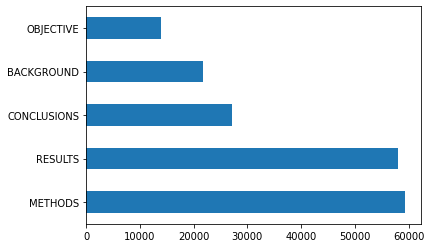

In [ ]:
# Check the distribution of target labels
train_df["target"].value_counts().plot.barh()

>🔑Well there is an imbalance of the training data

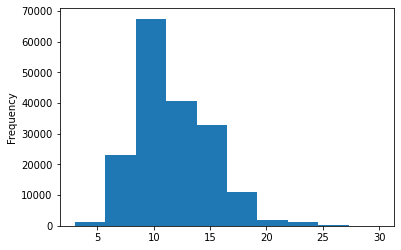

In [ ]:
# Check the lenght of different lines
train_df["total_lines"].plot.hist()

### Get list of sentences

In [ ]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML model requires numeric labels)

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf

tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [ ]:
# Get classes name and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments

* model 0: Naive Bayes with TF-IDF encoder (baseline).
* model 1: Conv1D with token embeddings.
* model 2: TensorFlow Hub pretrained feature extractor.
* model 3: Conv1D with character embeddings.
* model 4: Pretrained token embeddings (same as 2) + character embeddings (same as 3).
* model 5: Pretrained token embeddings + character embeddings + positional embeddings.

### Get helpers functions

In [ ]:
!wget https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py

--2021-08-25 12:33:03--  https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.98K  --.-KB/s    in 0s      

2021-08-25 12:33:03 (64.2 MB/s) - ‘helper_functions.py’ saved [11240/11240]



In [ ]:
from helper_functions import calculate_results

### Model 0 : Naive Bayes with TF-IDF encoder (baseline).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                     ("tfidf", TfidfVectorizer()), # Convert words into numbers using Tfidf
                     ("clf", MultinomialNB()) # The naive bayes for multinomial models
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# evaluate our base line model
baseline_score = model_0.score(test_sentences, test_labels_encoded)
baseline_score

0.716674962667994

In [ ]:
from sklearn.metrics import classification_report

model_0_pred = model_0.predict(test_sentences)

baseline_reports = classification_report(y_true=test_labels_encoded, y_pred=model_0_pred)
print(baseline_reports)

              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3621
           1       0.63      0.58      0.60      4571
           2       0.72      0.88      0.79      9897
           3       0.74      0.13      0.22      2333
           4       0.76      0.85      0.80      9713

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135



In [ ]:
model_0_results = calculate_results(y_true=test_labels_encoded, y_pred=model_0_pred)
model_0_results

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

## Preparing data for deep sequence models

Before going to build deep learning models, we have to create text vectorizer and embdding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

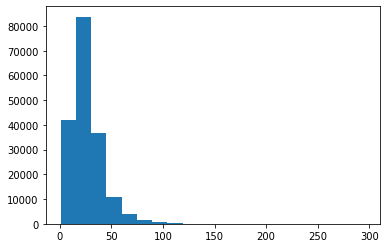

In [ ]:
# what the distribution look likes
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20)

In [ ]:
# calculate the length sentence that cover 95% of the training data
output_sent_lens = int(np.percentile(sent_lens, 95))
output_sent_lens

55

In [ ]:
# maximum the sentence lenght in the training dataset
max(sent_lens)

296

### Create word-level text vectorizer layers 

Make a layer to turn words to numbers

**Word-level**

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
!pip install keras

In [ ]:
# MAX vocabulary comes from this: https://arxiv.org/abs/1710.06071
MAX_VOCAB = 68000
MAX_LENGTHS = 55

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB,
                                    output_sequence_length=MAX_LENGTHS)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random

random_sentence = random.choice(train_sentences)
print(f"Text :\n {random_sentence}")
print(f"\nLength of the text: {len(random_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer(random_sentence)}")

Text :
 to evaluate ixekizumab , an anti-interleukin-@a ( anti-il-@a ) monoclonal antibody , in @ populations of rheumatoid arthritis ( ra ) patients : biologics-naive patients and patients with an inadequate response to tumor necrosis factor ( tnf ) inhibitors .

Length of the text: 40

Vectorized text: [    6   164 17017    26 23882 63774  3440  1029     5  1252     4  2339
  1535  1103    12 23752    12     3    12     7    26  2174   142     6
   724  2046   432  1558  1374     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [ ]:
# How many words in our vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create word-level text embedding layers

Make a layer to turn numbers into embedding matrix

In [ ]:
from tensorflow.keras.layers import Embedding

token_embedding = Embedding(input_dim=MAX_VOCAB,
                            output_dim=128,
                            mask_zero=True, # use masking to handle variable sequence lengths
                            name="token_embedding")

In [ ]:
# show sample embedding
print(f"Sentence: {random_sentence}")
vectorized_sentence = text_vectorizer(random_sentence)
print(f"\nVectorized sentence: {vectorized_sentence}, {vectorized_sentence.shape}")
token_embedded_sentence = token_embedding(vectorized_sentence)
print(f"\nToken embedded sentence: {token_embedded_sentence}, {token_embedded_sentence.shape}")

Sentence: to evaluate ixekizumab , an anti-interleukin-@a ( anti-il-@a ) monoclonal antibody , in @ populations of rheumatoid arthritis ( ra ) patients : biologics-naive patients and patients with an inadequate response to tumor necrosis factor ( tnf ) inhibitors .

Vectorized sentence: [    6   164 17017    26 23882 63774  3440  1029     5  1252     4  2339
  1535  1103    12 23752    12     3    12     7    26  2174   142     6
   724  2046   432  1558  1374     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], (55,)

Token embedded sentence: [[ 0.01017436  0.04472854 -0.02829078 ... -0.03753858  0.04356668
  -0.02166439]
 [-0.04681038 -0.01539098 -0.00148767 ...  0.03869598  0.0390884
   0.03115383]
 [-0.04261351  0.03974428  0.02952255 ... -0.04855244  0.0040692
   0.04983259]
 ...
 [-0.04604231 -0.00815129  0.01955065 ... -0.02565618  0.00843095
  -0.04941088]
 [-0.04604231 -0

### Create datasets (make sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with TensorFlow tf.data API:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turns our data into TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_ds = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_ds

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# create function for easy mapping
# def optimize_dataset(dataset):
#   return dataset.batch(32).prefect(tf.data.AUTOTUNE)

In [ ]:
# Take the TensorFlowSliceDatasets and turn them into prefetched dataset
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Continue with experiments

### Model 1: Conv1D with token embeddings

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
num_classes

5

In [ ]:
# create a model
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

x = text_vectorizer(inputs)
x = token_embedding(x) # output 128 dimension embedding matrix

x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same", name="Conv1D_layer")(x)
# x = layers.Flatten(name="flatten_layer")(x)
x = layers.GlobalAveragePooling1D(name="global_average_pool_1D")(x)

outputs = layers.Dense(num_classes, activation="softmax",name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D")

In [ ]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), # we use one hot label encoding
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8704000   
_________________________________________________________________
Conv1D_layer (Conv1D)        (None, 55, 64)            41024     
_________________________________________________________________
global_average_pool_1D (Glob (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
__________________________________________

In [ ]:
len(train_ds), len(val_ds)

(5627, 945)

In [ ]:
model_1_history = model_1.fit(train_ds,
                              steps_per_epoch=int(0.1 * len(train_ds)),
                              epochs=3,
                              validation_data=val_ds,
                              validation_steps=int(0.1 * len(val_ds)))

Epoch 1/3
562/562 [==============================] - 36s 8ms/step - loss: 0.8921 - accuracy: 0.6430 - val_loss: 0.6665 - val_accuracy: 0.7457
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6455 - accuracy: 0.7622 - val_loss: 0.6227 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6163 - accuracy: 0.7747 - val_loss: 0.5949 - val_accuracy: 0.7773


In [ ]:
# Evaluate on whole dataset
model_1.evaluate(val_ds)

945/945 [==============================] - 3s 3ms/step - loss: 0.5940 - accuracy: 0.7838


[0.5940350294113159, 0.7837614417076111]

In [ ]:
# Make predictions 
model_1_pred_probs = model_1.predict(val_ds)
model_1_pred = tf.squeeze(tf.argmax(model_1_pred_probs, axis=1))

In [ ]:
from helper_functions import calculate_results

model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=model_1_pred)
model_1_results

{'accuracy': 78.3761419303588,
 'f1': 0.7810488071290689,
 'precision': 0.7813274402636657,
 'recall': 0.783761419303588}

In [ ]:
model_0_results

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

> 🔥🔥🔥 wohooo! we have been beaten the baseline model.

### Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embddings from TensorFlow Hub, more specifically the Universal Sentence Encoder v4: https://tfhub.dev/google/universal-sentence-encoder/4

the paper originally used GloVe embeddings, however, we're going to stick with the later created USE v4 pretrained embedding.

**Sentence-level**

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# test out pretrained embdding on random sentence
random_sentence = random.choice(test_sentences)

print(f"Sentence: {random_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_sentence])
print(f"\nUSE embedded sentence: {use_embedded_sentence[0][:30]}, {use_embedded_sentence.shape}")

Sentence: during the @-month follow-up , the rate of subsequent mace ( @/@ ) was significantly lower in the triple group compared with the dual group ( @/@ ; p < @ ) .

USE embedded sentence: [ 0.00195522 -0.00361173 -0.02042856 -0.05097356 -0.00319013  0.05744607
  0.0540249  -0.07306065  0.03574327 -0.02824116  0.07611045 -0.00887992
  0.03412033 -0.01036068  0.00448572  0.04126102  0.00578947 -0.01215808
  0.06399027  0.02619894 -0.07808341 -0.02820256 -0.06261876 -0.03635207
 -0.02448299  0.03131892  0.00464332  0.0556401   0.01551006 -0.0565049 ], (1, 512)


In [ ]:
# Create model
inputs = layers.Input(shape=[], dtype=tf.string, name="input_layer")

x = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation="relu", name="hidden_layer_1")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extraction")

In [ ]:
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_ds,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_ds)),
                              validation_data=val_ds,
                              validation_steps=int(0.1 * len(val_ds)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9167 - accuracy: 0.6497 - val_loss: 0.7987 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7699 - accuracy: 0.7013 - val_loss: 0.7589 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7538 - accuracy: 0.7111 - val_loss: 0.7428 - val_accuracy: 0.7111


In [ ]:
# evaluate the model on the whole validation data
model_2.evaluate(val_ds)

945/945 [==============================] - 9s 9ms/step - loss: 0.7433 - accuracy: 0.7122


[0.7432634830474854, 0.7122335433959961]

In [ ]:
model_2_pred_probs = model_2.predict(val_ds)
model_2_pred = tf.squeeze(tf.argmax(model_2_pred_probs, axis=1))

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=model_2_pred)
model_2_results

{'accuracy': 71.22335495829472,
 'f1': 0.7092537441173501,
 'precision': 0.7121695186620425,
 'recall': 0.7122335495829472}

In [ ]:
model_0_results

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

> And the model 2 is perform worse than the base model 😥

### Model 3: Conv1D with character embeddings

The paper which we're replicating states they use a combination of token and character-level embedding.

Previously we've token-sentence-level embedding but we need to to do similar steps for characters if we want to use char-level embedding.


In [ ]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# split sequence-level data into char-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
# what the average sentence length?
chars_len = [len(sentence) for sentence in train_sentences]
avg_chars_len = np.mean(chars_len)
avg_chars_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

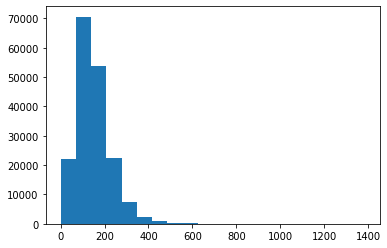

In [ ]:
# Check the distribution 
import matplotlib.pyplot as plt

plt.hist(chars_len, bins=20)

In [ ]:
# what chars length cover 95% of the training sentences
import numpy as np

np.percentile(chars_len, 95)

290.0

In [ ]:
# whats is the longest sentences
max(chars_len)

1386

### Create char-level token vectorizer instance

In [ ]:
# get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# what chars length cover 95% of the training sentences
import numpy as np

OUTPUT_SEQ_CHAR_LENGTH = int(np.percentile(chars_len, 95))
OUTPUT_SEQ_CHAR_LENGTH

290

In [ ]:
# from tensorflow.keras.layers import TextVectorization
NUM_CHARS_TOKEN = 68 + 2 # 2 two for space and OOV token 

char_vectorizer = TextVectorization(max_tokens=NUM_CHARS_TOKEN,
                                    output_sequence_length=OUTPUT_SEQ_CHAR_LENGTH,
                                    # standardize=None, #set standardize to none if you want to leave punctuation in.
                                    name="char_vectorizer")


In [ ]:
# adapt char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# check char vectorizer vocabularuy
# char_vocab = char_vectorizer.get_vocabulary()
rct_20k_char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of chars in vocabulary: {len(rct_20k_char_vocab)}")
print(f"Most common chars in vocabulary: {rct_20k_char_vocab[:5]}")
print(f"Least common chars in vocabulary: {rct_20k_char_vocab[-5:]}")

Number of chars in vocabulary: 28
Most common chars in vocabulary: ['', '[UNK]', 'e', 't', 'i']
Least common chars in vocabulary: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# test random character vectorizer
random_chars = random.choice(train_chars)
print(f"Charified sentence: {random_chars}")
print(f"\nLength of Charified sentence: {len(random_chars)}")
vectorized_chars = char_vectorizer(random_chars)
print(f"\nVectorized chars: {vectorized_chars}")
print(f"\nLength of Vectorized chars: {len(vectorized_chars)}")

Charified sentence: m e a n   f t   a n d   f z t   d i d   n o t   c h a n g e   s i g n i f i c a n t l y   d u r i n g   t h e   s t u d y   f o l l o w - u p   .

Length of Charified sentence: 145

Vectorized chars: [15  2  5  6 17  3  5  6 10 17 25  3 10  4 10  6  7  3 11 13  5  6 18  2
  9  4 18  6  4 17  4 11  5  6  3 12 19 10 16  8  4  6 18  3 13  2  9  3
 16 10 19 17  7 12 12  7 20 16 14  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Create char-level token embedding layers

In [ ]:
# Create char embdding layer
from tensorflow.keras.layers import Embedding

# (Old)
# char_embedding = Embedding(input_dim=len(rct_20k_char_vocab), # length of the chars vocab, 
#                            output_dim=25, # we are replicating the paper,https://arxiv.org/pdf/1612.05251.pdf so yeah, 25 dimension output
#                            mask_zero=True,
#                            name="char_embedding")

# New 
char_embedding = Embedding(input_dim=len(rct_20k_char_vocab), # length of the chars vocab, 
                           output_dim=25, # we are replicating the paper,https://arxiv.org/pdf/1612.05251.pdf so yeah, 25 dimension output
                           mask_zero=False, # if this set to True, it will mess up the model 5 :(
                           name="char_embedding")

In [ ]:
# Test our character embedding layer
print(f"Charified text: {random_chars}")
vectorized_chars = char_vectorizer(random_chars)
print(f"\nVectorized charified text {vectorized_chars}")
embedded_chars = char_embedding(vectorized_chars)
print(f"\nEmbedded charified text {embedded_chars}")
print(f"\nShape of Embedded charified text {embedded_chars.shape}")

Charified text: m e a n   f t   a n d   f z t   d i d   n o t   c h a n g e   s i g n i f i c a n t l y   d u r i n g   t h e   s t u d y   f o l l o w - u p   .

Vectorized charified text [15  2  5  6 17  3  5  6 10 17 25  3 10  4 10  6  7  3 11 13  5  6 18  2
  9  4 18  6  4 17  4 11  5  6  3 12 19 10 16  8  4  6 18  3 13  2  9  3
 16 10 19 17  7 12 12  7 20 16 14  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  

#### Create datasets for characters level

In [ ]:
train_chars_ds = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_chars_ds = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_chars_ds = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [ ]:
train_chars_ds = train_chars_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_ds = val_chars_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_ds = test_chars_ds.batch(32).prefetch(tf.data.AUTOTUNE)

#### Model 3:  Conv1D with character embeddings

In [ ]:
# Create a model
inputs =  layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

x = char_vectorizer(inputs)
x = char_embedding(x)

x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  name="Conv1D_layer")(x)
x = layers.GlobalMaxPooling1D(name="global_Max_pool_1D")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_char_embeddings")

In [ ]:
model_3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_3.summary()

Model: "model_3_Conv1D_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
Conv1D_layer (Conv1D)        (None, 290, 64)           8064      
_________________________________________________________________
global_Max_pool_1D (GlobalMa (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [ ]:
len(train_chars_ds)

5627

In [ ]:
model_3_history = model_3.fit(train_chars_ds,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_chars_ds)),
                              validation_data = val_chars_ds,
                              validation_steps=int(0.1 * len(val_chars_ds)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2601 - accuracy: 0.4875 - val_loss: 1.0317 - val_accuracy: 0.5908
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9943 - accuracy: 0.6021 - val_loss: 0.9253 - val_accuracy: 0.6400
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9194 - accuracy: 0.6377 - val_loss: 0.8606 - val_accuracy: 0.6725


>This is the worst model so far 😥

In [ ]:
# Let's evaluate model on full validation ds
model_3.evaluate(val_chars_ds)

945/945 [==============================] - 3s 3ms/step - loss: 0.8806 - accuracy: 0.6577


[0.8806231617927551, 0.6576856970787048]

In [ ]:
model_3_pred_prob = model_3.predict(val_chars_ds)
model_3_pred = tf.squeeze(tf.argmax(model_3_pred_prob, axis=1))
model_3_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 2, 2, 2, 2, 1, 4, 1])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_pred)
model_3_results

{'accuracy': 65.76856878061697,
 'f1': 0.646059793761602,
 'precision': 0.6492075049925944,
 'recall': 0.6576856878061698}

### Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding model)

1. Create token level embedding (similar to `model_1`).
2. Create char level embedding (similar to `model_3` with a slight modification).
3. Combine 1 & 2 with a concatenate (`layers.Concatenate()`).
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Source paper](https://arxiv.org/pdf/1612.05251.pdf).
5. Construct a model wich takes token and character-level sequences as input and produces sequence label probabilities as output.


In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeds = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeds)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=[], dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeds = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(units=24))(char_embeds)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

# 3. Combining two model
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
# 4. Create output layers - adding in Dropout, dicussed in paper
combined_dropout = layers.Dropout(rate=0.5, name="1st_dropout_layer")(token_char_concat) # prevent overfitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5, name="2nd_dropout_layer")(combined_dense)

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

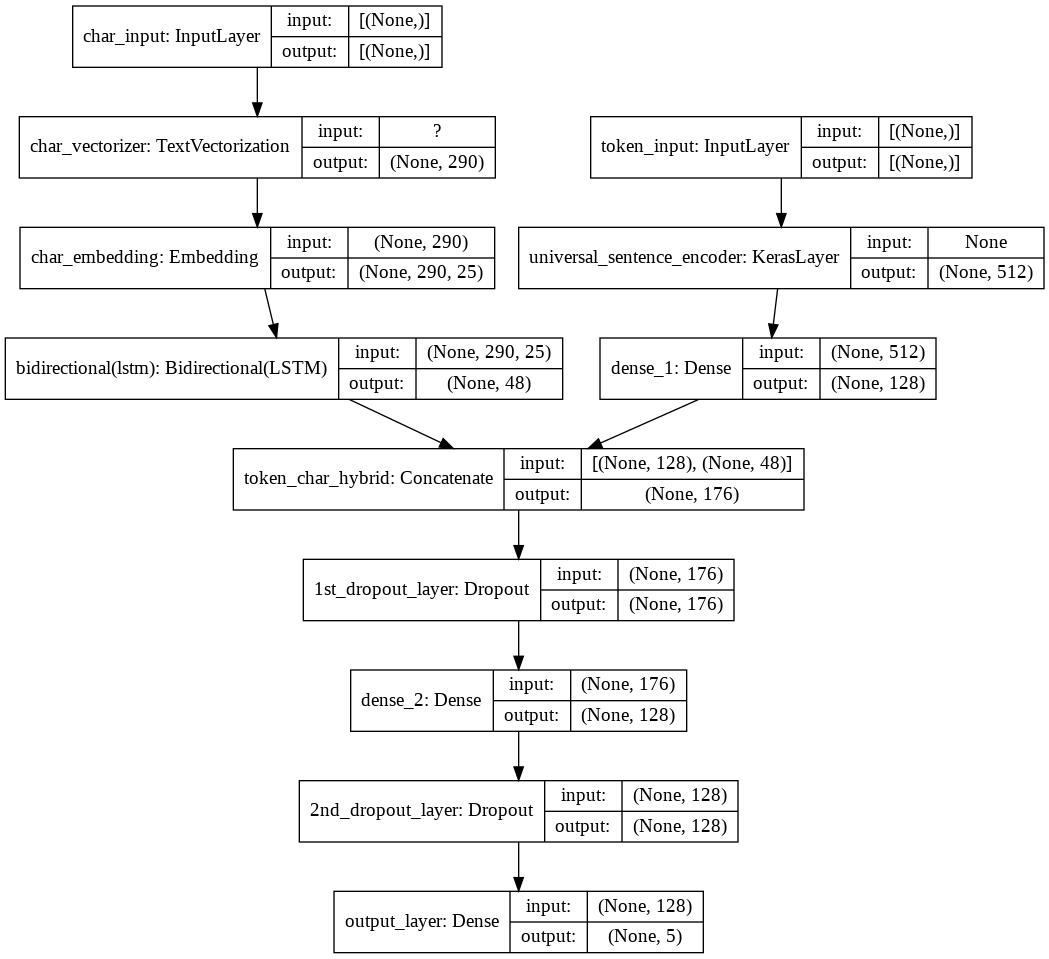

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(), # in the paper, they use SGD
    metrics=["accuracy"]
)

#### Create hybrid dataset for training

Combining token and character data into `tf.data.Dataset`

In [ ]:
# Combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_token_char_ds = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels
###-> [train_sentences, train_chars, train_labels_one_hot]
# Prefetch and batch train dataset
train_token_char_ds = train_token_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_token_char_ds = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
# batch val dataset and prefetch
val_token_char_ds = val_token_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)

############################
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_token_char_ds = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))
# batch test dataset and prefetch
test_token_char_ds = test_token_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_token_char_ds, val_token_char_ds

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

#### Fit the hybrid model

In [ ]:
len(train_token_char_ds)

5627

In [ ]:
model_4_history = model_4.fit(train_token_char_ds,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_token_char_ds)),
                              validation_data=val_token_char_ds,
                              validation_steps=int(0.1 * len(val_token_char_ds)))

Epoch 1/3
562/562 [==============================] - 23s 34ms/step - loss: 0.9891 - accuracy: 0.6076 - val_loss: 0.7756 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 0.8111 - accuracy: 0.6883 - val_loss: 0.7233 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 18s 33ms/step - loss: 0.7802 - accuracy: 0.7039 - val_loss: 0.7024 - val_accuracy: 0.7344


In [ ]:
# evaluate on the whole val dataset
model_4.evaluate(val_token_char_ds)

945/945 [==============================] - 19s 20ms/step - loss: 0.7058 - accuracy: 0.7319


[0.7057745456695557, 0.7318946123123169]

In [ ]:
model_4_pred_prob = model_4.predict(val_token_char_ds)
model_4_pred = tf.squeeze(tf.argmax(model_4_pred_prob, axis=1))

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_pred)
model_4_results

{'accuracy': 73.18946114126838,
 'f1': 0.7300613931586023,
 'precision': 0.7333590623788422,
 'recall': 0.7318946114126837}

In [ ]:
model_0_results

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

>well, it beat the baseline model but not improve much than `model_1`


In [ ]:
model_1_results

{'accuracy': 78.3761419303588,
 'f1': 0.7810488071290689,
 'precision': 0.7813274402636657,
 'recall': 0.783761419303588}

### Model 5: Pretrained token + character + positional embeddings.

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


>🔑**Note:** Any enigineered features used to train a model need to be available at test time. In our case, line numbers and total lines are must be available.

#### Create positional embedding

In [ ]:
# How many different line number are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

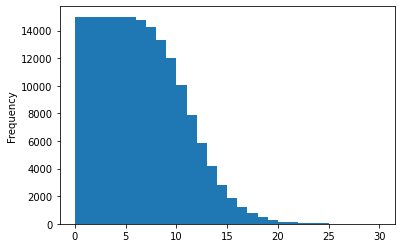

In [ ]:
# Check the distribution of line number
train_df.line_number.plot.hist(bins=30)

In [ ]:
# what line number will cover 95% percentile of line numbers
np.percentile(train_df["line_number"].to_numpy(), 95)

13.0

>🔑It look like we only need 15 depth of one-hot to cover 95% percent of the line number

In [ ]:
# use Tensorflow to create one-hot-encoded tensor of our line numbers
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now, we've encoded our line numbers feature, let's do the same with total_lines

In [ ]:
train_df["total_lines"].value_counts().sort_index()

3        32
4       215
5      1146
6      3353
7      7464
8     12285
9     19400
10    23639
11    24468
12    22113
13    18438
14    14610
15    10768
16     7429
17     5202
18     3344
19     2480
20     1281
21      770
22      759
23      264
24      200
25      182
26       81
27       28
28       58
30       31
Name: total_lines, dtype: int64

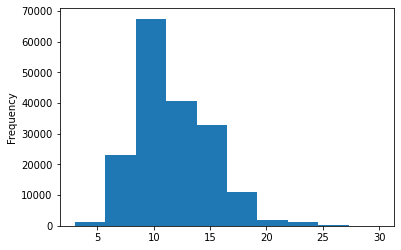

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
# what total lines cover 95% percent of the total lines?
np.percentile(train_df["total_lines"], 95)

18.0

>🔑well, we can use the same depth=15 from line number for total lines

In [ ]:
# Use Tensorflow to create one-hot-encoded tensor for our total_lines feature
train_total_line_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=15)
val_total_line_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=15)
test_total_line_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=15)

train_total_line_one_hot[:10], train_total_line_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

#### Building a tribrid embedding model

1. Create token-level model.
2. Create char-level model.
3. Create model for the "line_number" feature.
4. Create model for the "total_lines" feature.
5. Combine the outputs of 1 and 2 using the `tf.keras.layers.Concatenate()`.
6. Combine the 3, 4, 5 using the `tf.keras.layers.Concatenate()`.
7. Create an output layer to accept the tribried embedding and output label probabilities.
8. Combine the input of 1, 2, 3, 4 and outputs into a `tf.keras.Model()` 

In [ ]:
# 1. Create token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input", ragged=False)
token_embeds = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output")(token_embeds)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. Create char-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input", ragged=False)
char_vectors = char_vectorizer(char_inputs)
char_embeds = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, name="LSTM"), name="bi_LSTM")(char_embeds)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

# 3. Create line numbers model
# line number with one-hot vector 15 dimension depth
# Dense layer with 32 units & relu activation
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input", ragged=False)
line_number_outputs = layers.Dense(32, activation="relu", name="line_number_output")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,
                                   line_number_outputs,
                                   name="line_number_model")

# 4. Create total lines model
# same as line number model
total_line_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="total_line_input", ragged=False)
total_line_outputs = layers.Dense(32, activation="relu", name="total_line_output")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs,
                                  total_line_outputs,
                                  name="total_line_model")
# 5. Combine two model
hybrid_embeddings = layers.Concatenate(name="token_char_hybrid_embeddings")([token_model.output,
                                                                            char_model.output])

### create a dropout layers before create tribrid model
z = layers.Dense(256, activation="relu", name="dense_layer_1")(hybrid_embeddings)
z = layers.Dropout(0.5, name="dropout_layer_1")(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="token_char_positional_tribrid_embeddings")([z, # the hybrid model with dense and dropout layers
                                                                                          line_number_model.output,
                                                                                          total_line_model.output])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of input
model_5 = tf.keras.Model(inputs=[line_number_model.input, 
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid")

In [ ]:
model_5.summary()

Model: "model_5_tribrid"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
____________________________________________________________________________________

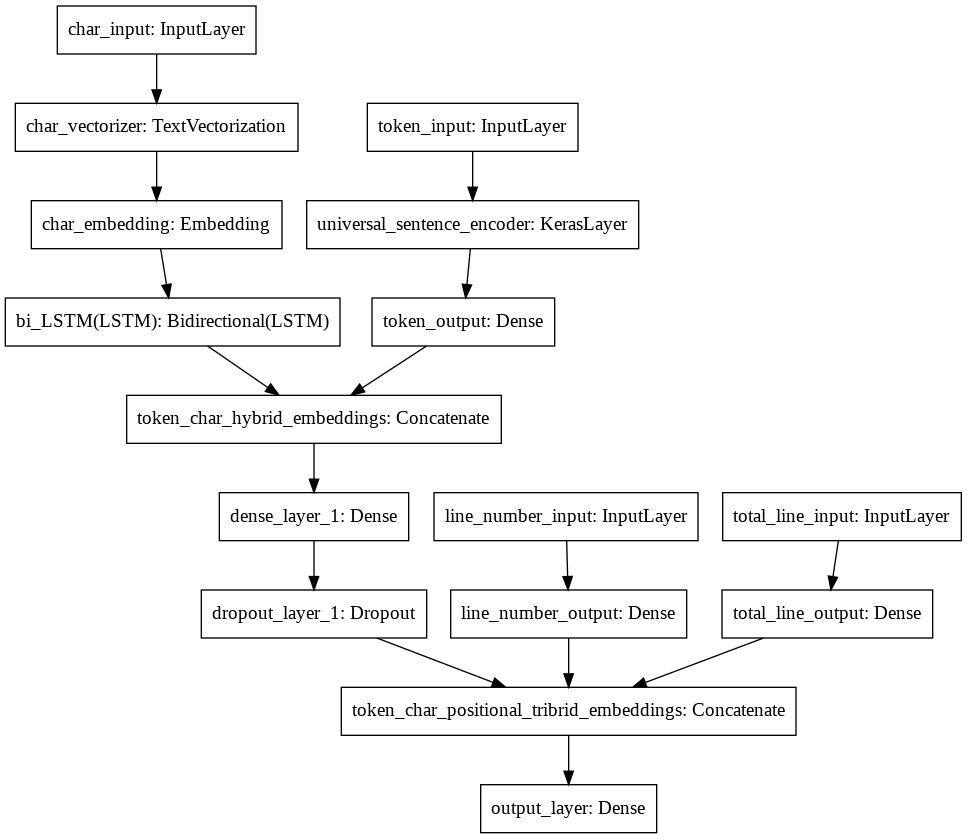

In [ ]:
plot_model(model_5)

What is label smoothing?

For example if our model gets too confident on a single class (e.g probability is really high),
it may get stuck on that class and not consider other classes...

Really confident: `[0.0., 1.0, 0.0, 0.0, 0.0]`

What label smoothing does is it assigns some of value from the high pred prob to other classes, in turn hopefully improving generalization.

Like this: `[0.01, 0.96, 0.01, 0.01, 0.01]`

>Read more: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile token, char and positional embedding model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


#### Create dataset for 2 additional feature

In [ ]:
# Combine chars and tokens into dataset
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_line_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_token_char_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_token_char_pos_ds = tf.data.Dataset.zip((train_token_char_pos_data, train_token_char_pos_labels))

train_token_char_pos_ds = train_token_char_pos_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Do the same with val and test dataset

val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                                val_total_line_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_token_char_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_char_pos_ds = tf.data.Dataset.zip((val_token_char_pos_data, val_token_char_pos_labels))
val_token_char_pos_ds = val_token_char_pos_ds.batch(32).prefetch(tf.data.AUTOTUNE)
#####

test_token_char_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                                test_total_line_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_token_char_pos_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_token_char_pos_ds = tf.data.Dataset.zip((test_token_char_pos_data, test_token_char_pos_labels))
test_token_char_pos_ds = test_token_char_pos_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check the input shapes
train_token_char_pos_ds

<PrefetchDataset shapes: (((None, 15), (None, 15), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

#### Fit the tribrid model

In [ ]:
model_5_history = model_5.fit(train_token_char_pos_ds,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_token_char_pos_ds)),
                              validation_data=val_token_char_pos_ds,
                              validation_steps=int(0.1 * len(val_token_char_pos_ds)))

Epoch 1/3
562/562 [==============================] - 23s 35ms/step - loss: 1.1020 - accuracy: 0.7194 - val_loss: 0.9849 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.9666 - accuracy: 0.8169 - val_loss: 0.9483 - val_accuracy: 0.8298
Epoch 3/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9499 - accuracy: 0.8240 - val_loss: 0.9383 - val_accuracy: 0.8338


In [ ]:
# evaluate on the whole validation dataset
model_5.evaluate(val_token_char_pos_ds)

945/945 [==============================] - 19s 20ms/step - loss: 0.9369 - accuracy: 0.8337


[0.9369389414787292, 0.8337415456771851]

In [ ]:
model_5_pred_prob = model_5.predict(val_token_char_pos_ds)
model_5_pred = tf.squeeze(tf.argmax(model_5_pred_prob, axis=1))

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded, y_pred=model_5_pred)
model_5_results

{'accuracy': 83.37415596451741,
 'f1': 0.832857820574262,
 'precision': 0.8329297009075258,
 'recall': 0.8337415596451742}

>🔥🔥🔥 Holy molly, this is the best model in our experiments

* We only train on 10% of the 20k dataset.

## Compare model results 

In [ ]:
# Combine model results into DataFrame
all_model_results = pd.DataFrame({"model_0_baseline": model_0_results, 
                                 "model_1_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_char_embedding": model_3_results,
                                 "model_4_char_token_embedding": model_4_results,
                                 "model_4_char_token_pos_embedding":model_5_results})

all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.716675,0.712432,0.716675,0.692510
model_1_token_embedding,0.783761,0.781327,0.783761,0.781049
model_2_pretrained_token_embedding,0.712234,0.712170,0.712234,0.709254
model_3_char_embedding,0.657686,0.649208,0.657686,0.646060
model_4_char_token_embedding,0.731895,0.733359,0.731895,0.730061
model_4_char_token_pos_embedding,0.833742,0.832930,0.833742,0.832858


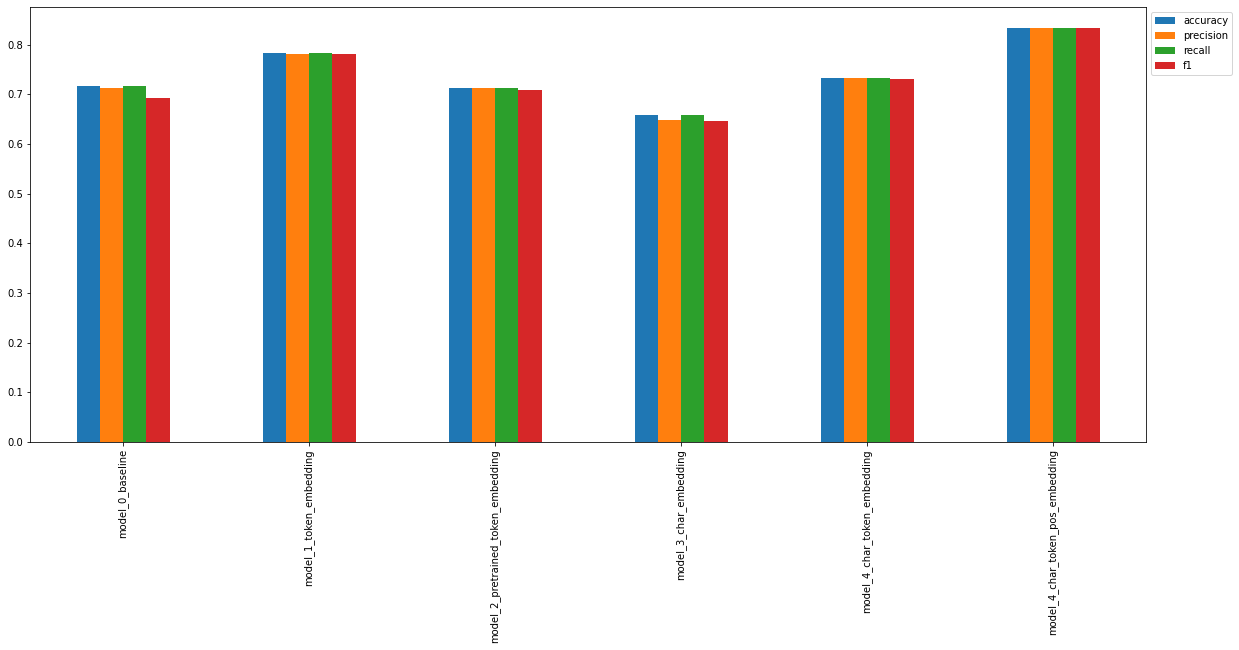

In [ ]:
# Plot and compare all model results
fig, ax = plt.subplots(figsize=(20,8))
# plt.xticks(rotation=70)
all_model_results.plot(kind="bar", ax=ax).legend(bbox_to_anchor=(1.0,1.0))

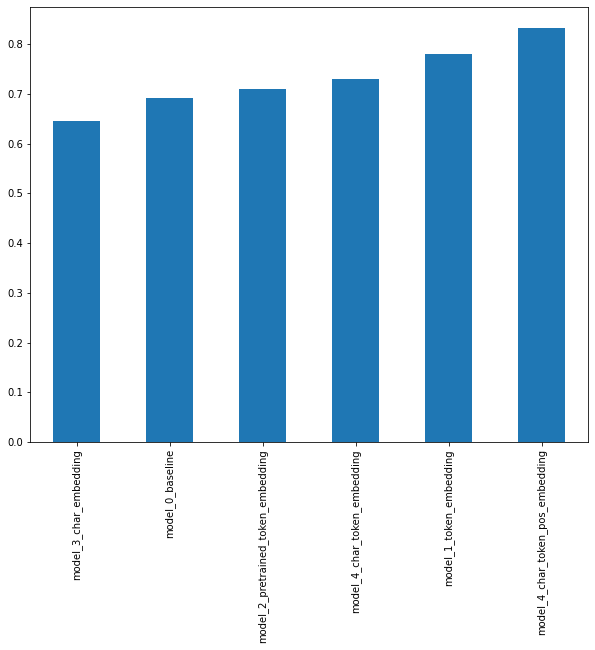

In [ ]:
# sort models results by f1-score 
all_model_results.sort_values("f1")["f1"].plot(kind="bar", figsize=(10,8))

## Save and load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the best model performing model to SavedModel format
model_5.save("09__skimlit_tribried_model", save_format='tf')

INFO:tensorflow:Assets written to: 09__skimlit_tribried_model/assets


INFO:tensorflow:Assets written to: 09__skimlit_tribried_model/assets


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "09__skimlit_tribried_model"
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
loaded_model.evaluate(val_token_char_pos_ds)

945/945 [==============================] - 130s 137ms/step - loss: 0.9370 - accuracy: 0.8343


[0.9370344281196594, 0.8342711329460144]

In [ ]:
loaded_model_pred_prob = loaded_model.predict(val_token_char_pos_ds)
loaded_model_pred = tf.squeeze(tf.argmax(loaded_model_pred_prob, axis=1))
loaded_model_results = calculate_results(y_true=val_labels_encoded, y_pred=loaded_model_pred)
loaded_model_results

{'accuracy': 83.42711505362108,
 'f1': 0.8332252253573114,
 'precision': 0.8331408194700209,
 'recall': 0.8342711505362108}

In [ ]:
# Download pretrained model from Google Storage
# !wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
# !mkdir skimlit_gs_model
# !unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
# import tensorflow_hub as hub
# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization

# model_path = "skimlit_gs_model/skimlit_tribrid_model"

# # Load downloaded model from Google Storage
# loaded_model = tf.keras.models.load_model(model_path,
#                                           custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
#                                                           "KerasLayer": hub.KerasLayer}) # required for token embedding

### Evaluate on test ds and find the most wrong

In [ ]:
# Make predictions on the tesat dataset
test_pred_probs = loaded_model.predict(test_token_char_pos_ds)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
test_df.drop(["pred_prob", "pred"], axis=1)

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [ ]:
test_preds_classes = [label_encoder.classes_[pred] for pred in test_preds]

In [ ]:
test_df["pred"] = test_preds_classes

In [ ]:
test_df.head()

,target,text,line_number,total_lines,pred,pred_prob
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.510447
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.340552
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.811124
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.617118
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.672449


In [ ]:
test_pred_probs.shape

(30135, 5)

In [ ]:
# test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1)
test_df["correct"] = test_df["pred"] == test_df["target"]

In [ ]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob",ascending=False)[:100]
top_100_wrong = top_100_wrong[["text", "target", "pred", "pred_prob"]]

In [ ]:
top_100_wrong

,text,target,pred,pred_prob
13874,symptom outcomes will be assessed and estimate...,CONCLUSIONS,METHODS,0.942951
2388,the primary endpoint is the cumulative three-y...,RESULTS,METHODS,0.939419
8545,pretest-posttest .,METHODS,BACKGROUND,0.934944
16347,to evaluate the effects of the lactic acid bac...,BACKGROUND,OBJECTIVE,0.923329
13598,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,METHODS,RESULTS,0.920187
...,...,...,...,...
4341,co-primary endpoints were lv end-systolic volu...,RESULTS,METHODS,0.834737
20040,chictr.org .,CONCLUSIONS,BACKGROUND,0.834364
9314,"in a randomized , controlled crossover trial ,...",RESULTS,METHODS,0.834317
18206,in a randomized controlled trial we examined t...,OBJECTIVE,METHODS,0.834276
